# Shortest Remaining Time Next

## Setting up firebase

In [10]:
# imports
import firebase_admin
from firebase_admin import credentials, firestore

# get the credential certificate from json file
cred = credentials.Certificate('jaynakum-experiments-88cc723f2db9.json')
# using the credentials initialize the firebase app
default_app = firebase_admin.initialize_app(cred, {'storageBucket': 'jaynakum-experiments.appspot.com'})
# initialize the database
db = firestore.client()

# initialize the main document reference
doc_ref = db.collection(u'CPU Scheduling')


ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

## Generate gantt chart and output table

In [ ]:
# imports
from matplotlib import pyplot as plt
from firebase_admin import storage

# method to generate gantt chart
def generateGanttChart(ganttChart: list) -> None:
  # create a figure and a set of subplots
  fig, gnt = plt.subplots()

  # set x-axis limit from 0 to the last entry of gantt chart
  gnt.set_xlim(0, ganttChart[(len(ganttChart) - 1)]['Exit Time'] + 1)
  # set y-axis limit to 1 because the chart is one line only
  gnt.set_ylim(0, 1)

  # set labels for both the axis
  gnt.set_xlabel('Time')
  gnt.set_ylabel('Process ID')

  # set y ticks and set labels = '' because there is no need to display it
  gnt.set_yticks([10, 20])
  gnt.set_yticklabels(['', ''])

  # the chart alternates between green and blue color
  # _isGreen flag is used to determine the color of broken_barh [broken bar horizontal]
  _isGreen = True
  for gantt in ganttChart:
    # _isGreen alternates between true and false
    _isGreen = not _isGreen
    # if true draw with green color else draw with blue
    if(_isGreen):
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4), facecolors=('tab:green'))
    else:
      # draw the broken_barh(start_time, duration_time)
      gnt.broken_barh([(gantt['Start Time'], (gantt['Exit Time'] - gantt['Start Time']))], (8, 4))
    # annotate the chart with the process' ID
    gnt.annotate(gantt['Process ID'], (gantt['Start Time'] + 0.2, 9.7))

  # save the output file
  plt.savefig('output/ganttChart.png')
  fileName = 'output/ganttChart.png'
  # print('Gantt Chart generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)

# method to generate output table
def generateOutput(outputProcesses: list, avgWT: int, avgTAT: int) -> None:
  # initializing a list of column lables
  columnLables = [
    'Process ID',
    'Arrival Time',
    'Burst Time',
    'Waiting Time',
    'Completion Time',
    'Turn Around Time',
    'Response Time'
  ]

  # making a list of each row(as list) from output 
  values = [[outputProcesses[i]['Process ID'], outputProcesses[i]['Arrival Time'], outputProcesses[i]['Burst Time'], outputProcesses[i]['Waiting Time'], outputProcesses[i]['Completion Time'], outputProcesses[i]['Turn Around Time'], outputProcesses[i]['Response Time']]for i in range(0, len(outputProcesses))]

  # set size and layout of output figure
  plt.rcParams["figure.figsize"] = [11.0, 3.0]
  plt.rcParams["figure.autolayout"] = True
  # create a figure and a set of subplots
  fig, table = plt.subplots()
  
  # turn off x and y axis
  table.set_axis_off()
  # enter the data into the table
  # cellText = values and colLabels = columnLabels with location center
  outputTable = table.table(cellText=values, colLabels=columnLables, cellLoc='center', loc='center')
  # scale the output image
  outputTable.scale(1.5, 1.5)
  # print 'Average Waiting Time' and 'Average Turn Around Time' in the image
  table.set_title('Average Waiting Time = ' + str(avgWT) + '\nAverage Turn Around Time = ' + str(avgTAT))

  # save the output file
  plt.savefig('output/outputTable.png')
  fileName = 'output/outputTable.png'
  # print('Output Table generated at: ' + fileName)

  # initialize the storage folder / bucket
  bucket = storage.bucket()
  # initialize the image blob
  blob = bucket.blob(fileName)
  # upload the image blob to firebase
  blob.upload_from_filename(fileName)


## Shortest Remaining Time First

[1, 2, 3, 3, 4, 6, 6, 2, 2, 2, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1]
Process	 Arrival Time	 Burst Time	 Waiting Time	 Turn Around Time	 completion Time	 Response Time
1	 0		 8		 12		 20			 20
2	 1		 4		 5		 9			 10
3	 2		 2		 0		 2			 4
4	 3		 1		 1		 2			 5
5	 4		 3		 6		 9			 13
6	 5		 2		 0		 2			 7

Average Waiting Time:  4.0
Average Turn Around:  7.333333333333333

 [{'Process ID': 1, 'Arrival Time': 0, 'Burst Time': 8, 'Completion Time': 20, 'Turn Around Time': 20, 'Waiting Time': 12, 'Response Time': 0}, {'Process ID': 2, 'Arrival Time': 1, 'Burst Time': 4, 'Completion Time': 10, 'Turn Around Time': 9, 'Waiting Time': 5, 'Response Time': 1}, {'Process ID': 3, 'Arrival Time': 2, 'Burst Time': 2, 'Completion Time': 4, 'Turn Around Time': 2, 'Waiting Time': 0, 'Response Time': 2}, {'Process ID': 4, 'Arrival Time': 3, 'Burst Time': 1, 'Completion Time': 5, 'Turn Around Time': 2, 'Waiting Time': 1, 'Response Time': 3}, {'Process ID': 5, 'Arrival Time': 4, 'Burst Time': 3, 'Completion Time': 

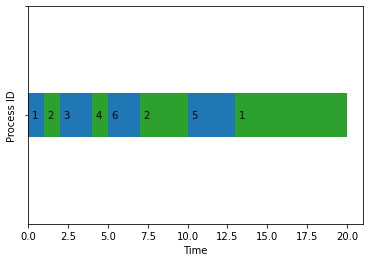

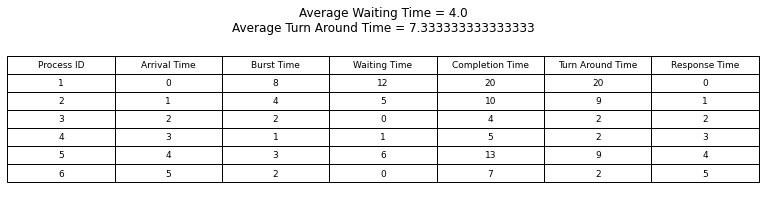

In [ ]:
# simulation of Shortest Time Remaining First algorithm

# add the values to gantt chart
def generateChart(rawGanttChart: list) -> list:
    gtTime = 0
    ganttChart = []
    gantt = {'Process ID': rawGanttChart[0], 'Start Time':gtTime, 'Exit Time': gtTime + 1} # where Start time  = gtTime and Exit time  = gtTime + 1
    ganttChart.append(gantt) 
    gt = 0
    gtTime += 1
    
    for g in range(1, len(rawGanttChart)):
        if rawGanttChart[g] == ganttChart[gt]['Process ID']:
            ganttChart[gt]['Exit Time'] += 1
        else:
            ganttChart.append({'Process ID': rawGanttChart[g], 'Start Time': gtTime, 'Exit Time': gtTime + 1})
            gt += 1
        gtTime += 1
    
    return ganttChart

# method to calculate TAT, WT and average of TAT and WT
def waitingTime(process, wt):
    n = len(process)
    rt = [0] * n
    rawGanttChart = []

    # Copy the burst time into rt[]
    for i in range(0, n):
        rt[i] = process[i]['Burst Time']

    complete = 0
    short = 0
    current_time = 0
    min_time = 999999999
    flag = False
    # Process until all processes gets
    # completed
    while (complete != n):
          # Find process with minimum remaining  time among the processes that arrives till the current time`
        for i in range(n):
            if process[i]['Arrival Time'] <= current_time and rt[i] < min_time and rt[i] > 0:
                min_time = rt[i]
                short = i
                flag = True

        if flag == False:
            current_time += 1
            continue

        rawGanttChart.append(process[short]['Process ID'])
        
        # Reduce remaining time by one
        rt[short] -= 1
        min_time = rt[short]


        # Update minimum
        if (min_time == 0):
            min_time = 99999999
            
        # If a process gets completely
                # executed
        if rt[short] == 0:
            complete += 1
            flag = False
            completion_time = current_time + 1
            # calculating Waiting time
            wt[short] = completion_time - process[short]['Arrival Time'] - process[short]['Burst Time']
            # wt = tat-bt or  (ct-at)-bt

            if wt[short] < 0:
                wt[short] = 0

        current_time += 1
    # completion time For Each Process
    print(rawGanttChart)
    ganttChart = generateChart(rawGanttChart)
    generateGanttChart(ganttChart)
    for gantt in ganttChart:
        for p in process:
            if p['Process ID'] == gantt['Process ID']:
                p['Completion Time'] = gantt['Exit Time']
            # note the 'Response Time' of each process
            if 'Response Time' in p.keys():
                pass
            else:
                p['Response Time'] = (p['Arrival Time'])
    # print(process)
    
    # note the 'Response Time' of each process
    
# Function to calculate turn around time
def turnAroundtime(process, wt, tat):
# Calculating turnaround time
    for i in range(len(process)):
        tat[i] = process[i]['Burst Time'] + wt[i]

# Function to calculate average waiting and turn-around times.
def avgTime(process):
    n = len(process)
    wt = [0] * n
    tat = [0] * n
    total_wt = 0
    total_tat = 0

    waitingTime(process, wt) # Function to find waiting time of all processes
    turnAroundtime(process, wt, tat)# Function to find turn around time for all processes

    for i in range(n):
        total_wt = total_wt + wt[i]
        total_tat = total_tat + tat[i]

    avg_wt = total_wt / n
    avg_tat = total_tat / n

    display(process, wt, tat, avg_wt, avg_tat)

# Time Complexity of Algorithm is O(n^2)
def display(process, wt, tat, avg_wt, avg_tat):
    print(
        'Process\t Arrival Time\t Burst Time\t Waiting Time\t Turn Around Time\t completion Time\t Response Time'
    )
#  Display processes along with all details in table
    for i in range(len(process)):
        print('{}\t {}\t\t {}\t\t {}\t\t {}\t\t\t {}'.format(process[i]['Process ID'],
                                                    process[i]['Arrival Time'],
                                                    process[i]['Burst Time'],
                                                    wt[i], tat[i],
                                                    process[i]['Completion Time'], process[i]['Response Time']))

    print('\nAverage Waiting Time: ', avg_wt)
    print('Average Turn Around: ', avg_tat)
    output = []
#  Display processes along with all details in dict
    for i in range(len(process)):
        output.append({
            'Process ID': process[i]['Process ID'],
            'Arrival Time': process[i]['Arrival Time'],
            'Burst Time': process[i]['Burst Time'],
            'Completion Time': process[i]['Completion Time'],
            'Turn Around Time': tat[i],
            'Waiting Time': wt[i],
            'Response Time': process[i]['Response Time']
        })
    output.sort(key=lambda process: process['Arrival Time'])

    print('\n', output)
    generateOutput(output, avgWT= avg_wt, avgTAT= avg_tat)


## Get input from firebase

Received new document snapshot: First Come First Serve
[{'Process ID': 0, 'Burst Time': 1, 'Arrival Time': 0}, {'Burst Time': 5, 'Arrival Time': 2, 'Process ID': 1}, {'Process ID': 2, 'Arrival Time': 3, 'Burst Time': 5}]


KeyboardInterrupt: ignored

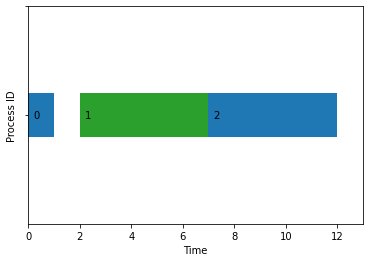

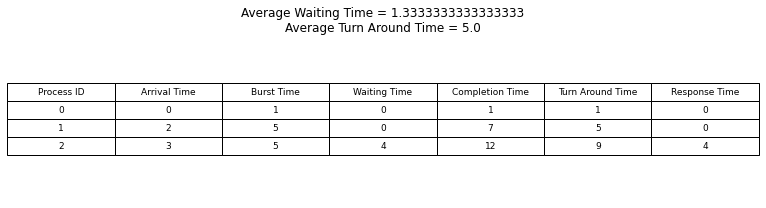

In [ ]:
# imports
import threading
import time

# Create an Event for notifying main thread.
callback_done = threading.Event()

# Create a callback on_snapshot function to capture changes
def on_snapshot(doc_snapshot, changes, read_time):
  for change in changes:
    # Check for a change in document
    if change.type.name == 'MODIFIED':
      # print(u'Change: {}'.format(change.document.id))
      # iterate through each document snapshot
      for doc in doc_snapshot:
        print(f'Received new document snapshot: {doc.id}')
        # initialize the input processes
        input = doc.to_dict()
        inputProcesses = input['Processes']
        print(inputProcesses)
        # dict containing the processes, gantt chart, average waiting time and average turn around time
        avgTime(inputProcesses)

    # return the control to document watch
    callback_done.set()

# Watch the document
doc_watch = doc_ref.on_snapshot(on_snapshot)

# Keep the app running
while True:
    time.sleep(1)
    # print('watching')
